In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pydot

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import os

In [3]:
aapl = yf.Ticker('AAPL').history(start = '2013-01-01', end = '2023-01-01')
aapl = aapl.drop(columns= ['Dividends', 'Stock Splits'])
aapl.ffill(inplace = True)
aapl.reset_index(inplace = True)

In [4]:
aapl['open-close'] = aapl['Open'] - aapl['Close']
aapl['high-low'] = aapl['High'] - aapl['Low']

intervals = [5, 30, 60, 252]
for interval in intervals:
    aapl[f'ema{interval}'] = aapl['Close'] / aapl['Close'].ewm(span = interval).mean()
    aapl[f'ave{interval}'] = aapl['Close'] / aapl['Close'].rolling(interval, min_periods = 1).mean()

delta = aapl['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down
aapl['RSI'] = 100 - (100 / (1 + rs))

exp1 = aapl['Close'].ewm(span=12, adjust=False).mean()
exp2 = aapl['Close'].ewm(span=26, adjust=False).mean()
aapl['MACD'] = exp1 - exp2

aapl['norm_vol'] = aapl['Volume'] / aapl['Volume'].ewm(5).mean()
aapl['vol_change'] = aapl['Volume'].pct_change()

aapl.replace([np.inf, -np.inf], 0, inplace = True)
aapl = aapl.dropna(how = 'any', axis= 0)
aapl = aapl.drop(columns= ['Open', 'High', 'Low', 'Volume'])
aapl.head()

,Date,Close,open-close,high-low,ema5,ave5,ema30,ave30,ema60,ave60,ema252,ave252,RSI,MACD,norm_vol,vol_change
1,2013-01-03 00:00:00-05:00,16.557432,0.176539,0.264809,0.994913,0.993649,0.993859,0.993649,0.993754,0.993649,0.993674,0.993649,0.000000,-0.016884,0.789089,-0.370287
2,2013-01-04 00:00:00-05:00,16.096230,0.304515,0.390953,0.982464,0.977054,0.977945,0.977054,0.977498,0.977054,0.977159,0.977054,0.000000,-0.066711,1.175800,0.683831
3,2013-01-07 00:00:00-05:00,16.001547,-0.058032,0.430657,0.986236,0.978324,0.979699,0.978324,0.979013,0.978324,0.978488,0.978324,0.000000,-0.112543,0.971012,-0.185379
4,2013-01-08 00:00:00-05:00,16.044611,0.119118,0.324978,0.993126,0.984708,0.986299,0.984708,0.985510,0.984708,0.984900,0.984708,1.484381,-0.143732,0.940955,-0.052564
5,2013-01-09 00:00:00-05:00,15.793853,0.164932,0.275500,0.985671,0.981062,0.976447,0.974300,0.975381,0.974300,0.974559,0.974300,1.357976,-0.186534,0.871932,-0.111406


In [5]:
features = list(aapl.columns[1:])
features

['Close',
 'open-close',
 'high-low',
 'ema5',
 'ave5',
 'ema30',
 'ave30',
 'ema60',
 'ave60',
 'ema252',
 'ave252',
 'RSI',
 'MACD',
 'norm_vol',
 'vol_change']

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_columns = scaler.fit_transform(aapl[features])
aapl_scaled = pd.DataFrame(scaled_columns, columns=features)

train_size = int(len(aapl_scaled) * 0.9)
train, test = aapl_scaled[:train_size], aapl_scaled[train_size - 60:]

In [7]:
def create_dataset(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

time_steps = 60
X_train = create_dataset(train, time_steps)
X_test = create_dataset(test, time_steps)

y_train = train[features].values[time_steps:]
y_test = test[features].values[time_steps:]

In [8]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_models = {}
train_predictions = {}
test_predictions = {}

folder_path = f'C:\\Users\\pc\\OneDrive\\桌面\\CSE 6740\\Final Project\\h5\\AAPL'

for feature in features:
    model_path = os.path.join(folder_path, f'AAPL_lstm_xgboost_model_{feature}.h5')
    lstm_model = load_model(model_path)
    # print(f"Training model for {feature}")
    # lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    feature_index = train.columns.get_loc(feature)
    # lstm_model.fit(X_train, y_train[:, feature_index], epochs=100, batch_size=64, verbose=1, validation_split=0.1)

    train_pred = lstm_model.predict(X_train)
    test_pred = lstm_model.predict(X_test)

    train_predictions[feature] = train_pred
    test_predictions[feature] = test_pred

    lstm_models[feature] = lstm_model


8/8 [==============================] - 0s 7ms/step


In [14]:
train_pred.shape

(2205, 1)

In [10]:
train_predictions

{'Close': array([[-0.01386132],
        [-0.01448859],
        [-0.01283009],
        ...,
        [ 0.987056  ],
        [ 0.9820068 ],
        [ 0.98326844]], dtype=float32),
 'open-close': array([[0.59230655],
        [0.5916599 ],
        [0.5919738 ],
        ...,
        [0.59382725],
        [0.5881103 ],
        [0.58440423]], dtype=float32),
 'high-low': array([[0.02358657],
        [0.02500201],
        [0.01591224],
        ...,
        [0.29306403],
        [0.30351976],
        [0.28687042]], dtype=float32),
 'ema5': array([[0.40268558],
        [0.4282679 ],
        [0.47823942],
        ...,
        [0.6626084 ],
        [0.59401447],
        [0.5916697 ]], dtype=float32),
 'ave5': array([[0.34440285],
        [0.3937059 ],
        [0.47196454],
        ...,
        [0.6027138 ],
        [0.52235264],
        [0.5070696 ]], dtype=float32),
 'ema30': array([[0.43520376],
        [0.4280554 ],
        [0.44514126],
        ...,
        [0.77745104],
        [0.7327504 ],
 

In [15]:
train_preds

array([[-0.01386132,  0.59230655,  0.02358657, ...,  0.4565591 ,
         0.30087855,  0.19058917],
       [-0.01448859,  0.5916599 ,  0.02500201, ...,  0.45185804,
         0.34100282,  0.16583557],
       [-0.01283009,  0.5919738 ,  0.01591224, ...,  0.45184293,
         0.2822106 ,  0.20471664],
       ...,
       [ 0.987056  ,  0.59382725,  0.29306403, ...,  0.90383095,
         0.21691334,  0.2457299 ],
       [ 0.9820068 ,  0.5881103 ,  0.30351976, ...,  0.9010955 ,
         0.23293592,  0.23563975],
       [ 0.98326844,  0.58440423,  0.28687042, ...,  0.89490646,
         0.22749071,  0.28508645]], dtype=float32)

In [11]:
train_preds = np.column_stack(list(train_predictions.values()))
test_preds = np.column_stack(list(test_predictions.values()))

In [ ]:
target_feature = 'Close'
y_train_target = y_train[:, features.index(target_feature)]
y_test_target = y_test[:, features.index(target_feature)]

In [ ]:
train_preds_df = pd.DataFrame(train_preds, columns=features)

In [ ]:
y_train_target

array([0.00718112, 0.00758351, 0.00680249, ..., 0.98398801, 0.98451785,
       0.97757166])

In [ ]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(xgb_model, parameters)
clf.fit(train_preds_df, y_train_target)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.8667312565528219


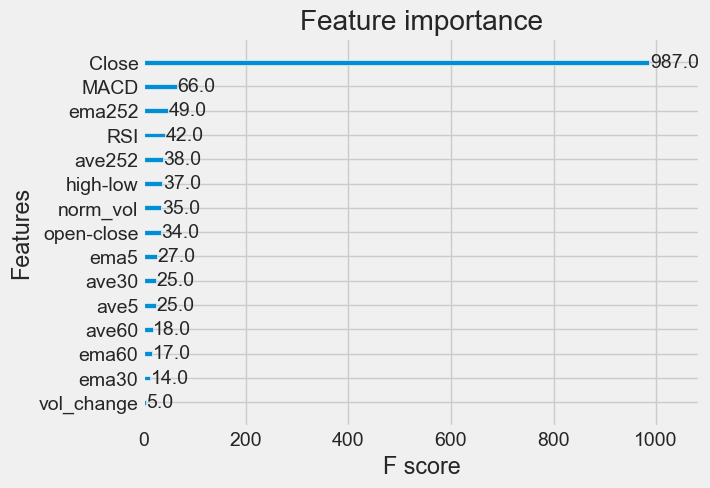

In [ ]:
model = clf.best_estimator_
plot_importance(model)
plt.show()

In [ ]:
y_pred = model.predict(test_preds)

close_index = 0

y_pred_reshaped = np.zeros((y_pred.shape[0], len(scaler.scale_)))
y_pred_reshaped[:, close_index] = y_pred.flatten()
y_pred = scaler.inverse_transform(y_pred_reshaped)[:, close_index]

y_test_target_reshaped = np.zeros((y_test_target.shape[0], len(scaler.scale_)))
y_test_target_reshaped[:, close_index] = y_test_target.flatten()
y_test_target = scaler.inverse_transform(y_test_target_reshaped)[:, close_index]

print(f'y_true = {np.array(y_test_target)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test_target, y_pred)}')
print(f'mean_absolute_error = {mean_absolute_error(y_test_target, y_pred)}')


y_true = [175.56407166 179.95391846 177.66998291 172.94400024 170.05697632]
y_pred = [174.92912665 173.20656714 172.05792717 171.74183043 166.43140531]
mean_squared_error = 20.391559819960914
mean_absolute_error = 3.6043894734775583


In [ ]:
test_split_idx = train_size

dates = aapl['Date'][test_split_idx:].reset_index(drop=True)
predicted_prices = pd.DataFrame(data={'Date': dates, 'Close_Predicted': y_pred.flatten(), 'Close_Actual': y_test_target.flatten()})

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=aapl['Date'], y=aapl[target_feature], name='Truth', marker_color='LightSkyBlue'), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_prices['Date'], y=predicted_prices['Close_Predicted'], name='Prediction', marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices['Date'], y=predicted_prices['Close_Actual'], name='Truth', marker_color='LightSkyBlue', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=predicted_prices['Date'], y=predicted_prices['Close_Predicted'], name='Prediction', marker_color='MediumPurple', showlegend=False), row=2, col=1)


fig.show()

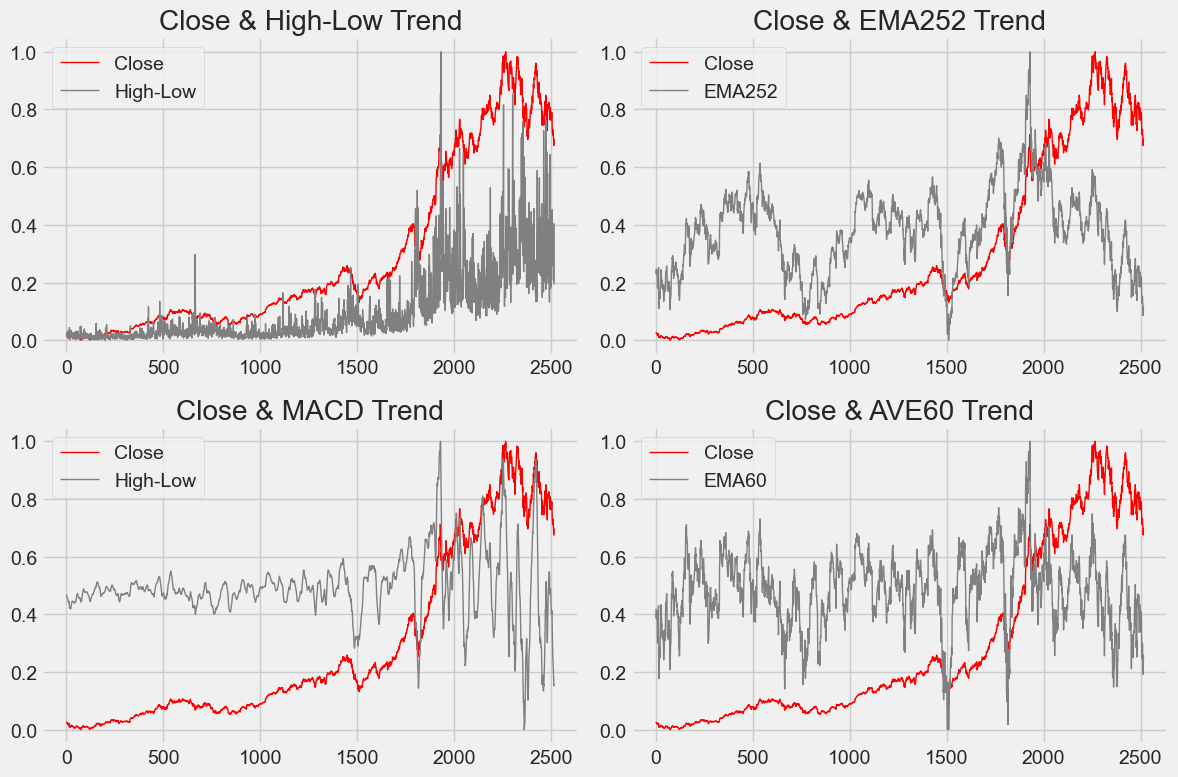

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# 分别绘制每个特征
axes[0, 0].plot(aapl_scaled['Close'], label='Close', color='red', linewidth=1)
axes[0, 0].plot(aapl_scaled['high-low'], label='High-Low', color='grey', linewidth=1)
axes[0, 0].set_title('Close & High-Low Trend')
axes[0, 0].legend()

axes[0, 1].plot(aapl_scaled['Close'], label='Close', color='red', linewidth=1)
axes[0, 1].plot(aapl_scaled['ema252'], label='EMA252', color='grey', linewidth=1)
axes[0, 1].set_title('Close & EMA252 Trend')
axes[0, 1].legend()

axes[1, 0].plot(aapl_scaled['Close'], label='Close', color='red', linewidth=1)
axes[1, 0].plot(aapl_scaled['MACD'], label='High-Low', color='grey', linewidth=1)
axes[1, 0].set_title('Close & MACD Trend')
axes[1, 0].legend()

axes[1, 1].plot(aapl_scaled['Close'], label='Close', color='red', linewidth=1)
axes[1, 1].plot(aapl_scaled['ema60'], label='EMA60', color='grey', linewidth=1)
axes[1, 1].set_title('Close & AVE60 Trend')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
correlation_matrix = aapl.corr()
close_correlations = correlation_matrix['Close']
close_correlations = close_correlations.drop('Close')
close_correlations

C:\Users\pc\AppData\Local\Temp\ipykernel_4616\1159586572.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



open-close   -0.033854
high-low      0.807224
ema5          0.014937
ave5          0.013329
ema30         0.044150
ave30         0.040551
ema60         0.067576
ave60         0.062538
ema252        0.240960
ave252        0.177661
RSI           0.007129
MACD          0.172232
norm_vol      0.010546
vol_change   -0.023889
Name: Close, dtype: float64

In [ ]:
aapl_scaled

,Close,open-close,high-low,ema5,ave5,ema30,ave30,ema60,ave60,ema252,ave252,RSI,MACD,norm_vol,vol_change
0,0.027149,0.599671,0.013108,0.486004,0.455593,0.502850,0.507967,0.419601,0.431423,0.247988,0.235069,0.000000,0.468280,0.213665,0.089815
1,0.024403,0.607170,0.023228,0.406674,0.365758,0.458194,0.467766,0.387085,0.402390,0.229881,0.218507,0.000000,0.464709,0.387347,0.366660
2,0.023840,0.585927,0.026414,0.430715,0.372638,0.463116,0.470844,0.390115,0.404613,0.231338,0.219775,0.000000,0.461424,0.295371,0.138378
3,0.024096,0.596307,0.017935,0.474620,0.407192,0.481638,0.486308,0.403111,0.415781,0.238368,0.226146,0.016367,0.459188,0.281872,0.173259
4,0.022603,0.598991,0.013966,0.427112,0.387457,0.453991,0.461096,0.382850,0.397573,0.227029,0.215759,0.014973,0.456121,0.250872,0.157805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.709288,0.534556,0.213655,0.439828,0.449958,0.337002,0.324576,0.260014,0.298761,0.126583,0.091034,0.393564,0.208988,0.205794,0.139710
2513,0.698453,0.667988,0.206475,0.406825,0.394119,0.313720,0.303769,0.240496,0.277937,0.114124,0.080325,0.371299,0.189981,0.244632,0.208436
2514,0.674829,0.800836,0.403535,0.312675,0.280167,0.250638,0.247301,0.192126,0.232195,0.085937,0.055730,0.327761,0.155588,0.331481,0.249596
2515,0.695967,0.494934,0.211261,0.497673,0.475645,0.334388,0.318715,0.247644,0.278788,0.113189,0.079782,0.406418,0.152518,0.282502,0.157140


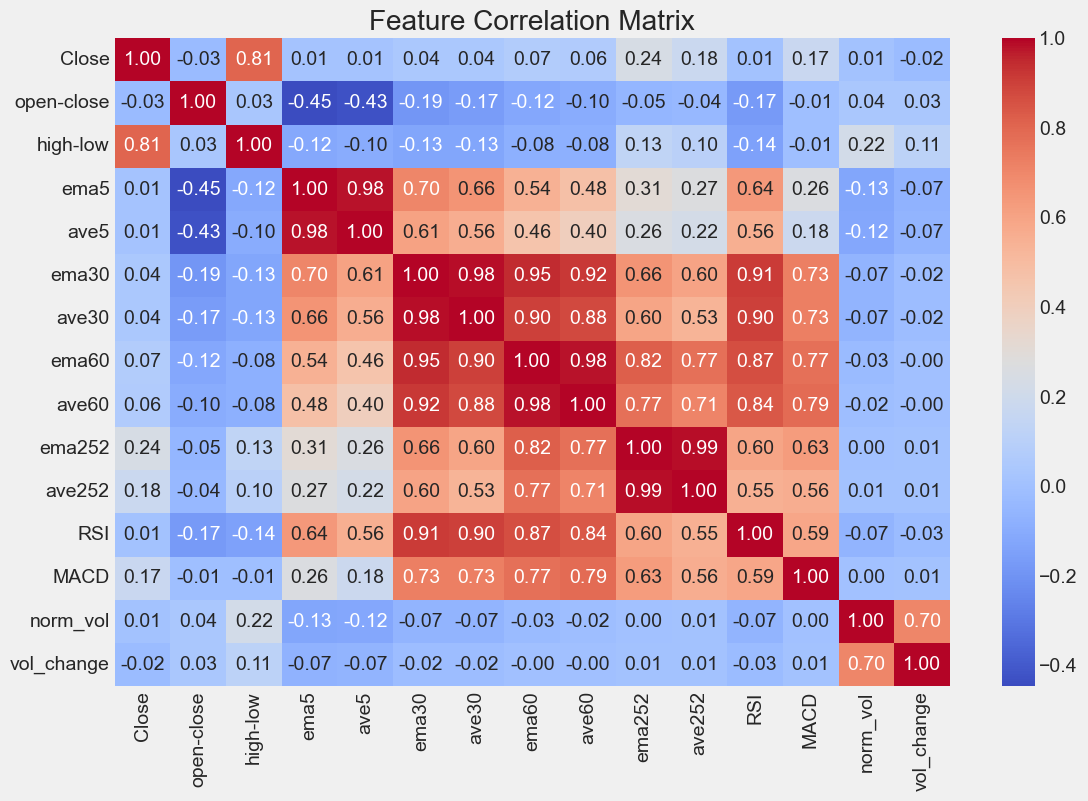

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = aapl_scaled.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()